# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
class StdScaler:
    def __init__(self, type: str = "std"):
        self.mean = None
        self.std = None

    def fit(self, X: np.ndarray):
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X - self.mean) / self.std

    def fit_transform(self, X: np.ndarray):
        return self.fit(X).transform(X)

    def reverse(self, X: np.ndarray) -> np.ndarray:
        return X * self.std + self.mean

In [3]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [4]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [5]:
def mse(y_true: np.ndarray, y_predicted: np.ndarray):
    return np.sum((y_true - y_predicted) ** 2) / y_true.shape[0]

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    y_mean = np.mean(y_true)
    return 1 - np.sum((y_predicted - y_true) ** 2) / np.sum((y_true - y_mean) ** 2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [6]:
class NormalLR:
    def __init__(self, normalizeX: bool = True, normalizeY: bool = True):
        self.normalizeX = normalizeX
        self.normalizeY = normalizeY

        self.w = None
        self.scalerX = StdScaler() if self.normalizeX else None
        self.scalerY = StdScaler() if self.normalizeY else None

    def _prepX(self, X: np.ndarray):
        if self.normalizeX:
            X_ = self.scalerX.fit_transform(X)
        else:
            X_ = X
        return np.hstack((X_, np.ones(shape=(X_.shape[0], 1))))

    def _prepY(self, y: np.ndarray):
        if self.normalizeY:
            return self.scalerY.fit_transform(y)
        else:
            return y

    def fit(self, X: np.ndarray, y: np.ndarray):
        X_ = self._prepX(X)
        y_ = self._prepY(y)
        self.w = np.linalg.inv(X_.T @ X_) @ X_.T @ y_
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        X_ = self._prepX(X)
        pred = X_ @ self.w

        if self.normalizeY:
            pred = self.scalerY.reverse(pred)
        return pred

In [7]:
regr = NormalLR()
mse_ = []
r2_ = []
for _ in range(1000):
    X, y = generate_synthetic(1024)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    mse_.append(mse(y_test, y_pred))
    r2_.append(r2(y_test, y_pred))
print(f"MSE: {np.mean(mse_)}, R2: {np.mean(r2_)}")

MSE: 0.06681141370878299, R2: 0.9881368122432227


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0., eps: float = 1e-8, normalizeX: bool = True, normalizeY: bool = True):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.eps = eps
        self.normalizeX = normalizeX
        self.normalizeY = normalizeY

        self.w = None
        self.scalerX = StdScaler() if self.normalizeX else None
        self.scalerY = StdScaler() if self.normalizeY else None

    def _prepX(self, X: np.ndarray):
        if self.normalizeX:
            X_ = self.scalerX.fit_transform(X)
        else:
            X_ = X
        return np.hstack((X_, np.ones(shape=(X_.shape[0], 1))))

    def _prepY(self, y: np.ndarray):
        if self.normalizeY:
            return self.scalerY.fit_transform(y)
        else:
            return y

    def fit(self, X:np.ndarray, y:np.ndarray):
        X_ = self._prepX(X)
        y_ = self._prepY(y)
        n = X_.shape[0]
        w = np.zeros(shape=(X_.shape[1]))
        d = X_.T @ y_ / n
        
        eps = self.eps * d.T @ d
        for _ in range(self.iterations):
            if d.T @ d <= eps:
                break
            w += d * self.alpha
            d = -(X_.T @ (X_ @ w - y_) / n + self.l * np.sign(w))
        self.w = w.copy().ravel()

    def predict(self, X: np.ndarray):
        X_ = self._prepX(X)
        pred = X_ @ self.w

        if self.normalizeY:
            pred = self.scalerY.reverse(pred)
        return pred

In [9]:
def build_plot(X_train, y_train, X_test, y_test, alpha = 0.1, left = 0, right = 0.002, normalizeX: bool = True, normalizeY: bool = True):
    xs = np.linspace(left, right, 100)
    errors = []
    for x in xs:
        regr = GradientLR(alpha, iterations=10000, l=x, normalizeX = normalizeX, normalizeY = normalizeY)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.ylabel("MSE")
    plt.xlabel("l")
    plt.show()

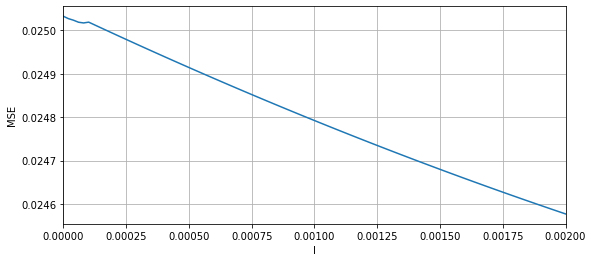

In [10]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
build_plot(X_train, y_train, X_val, y_val, right=0.002)

In [11]:
regr = GradientLR(0.1, iterations=10000, l=0.00125)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.07517745697160856, R2: 0.9683263635144849


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [12]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.5, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size=0.5, shuffle=True)

In [18]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"Validate\nMSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

Validate
MSE: 28074195.539831214, R2: 0.6784685452094443


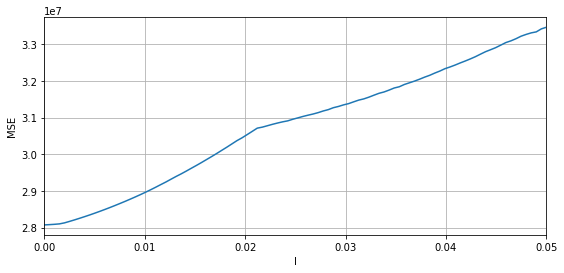

In [19]:
build_plot(X_train, y_train, X_val, y_val, right=0.05, alpha=0.01)

In [20]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"Validate\nMSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

Validate
MSE: 28072554.336088754, R2: 0.6784873417810565


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [21]:
names = """\
    #  1. crim     per capita crime rate by town
    #  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
    #  3. indus    proportion of non-retail business acres per town
    #  4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    #  5. nox      nitric oxides concentration (parts per 10 million)
    #  6. rm       average number of rooms per dwelling
    #  7. age      proportion of owner-occupied units built prior to 1940
    #  8. dis      weighted distances to five Boston employment centres
    #  9. rad      index of accessibility to radial highways
    # 10. tax      full-value property-tax rate per $10,000
    # 11. ptratio  pupil-teacher ratio by town
    # 12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    # 13. lstat    % lower status of the population\
""".split("\n")

In [22]:
for item, name in sorted(zip(regr.w, names), key=lambda x: abs(x[0])):
    print(f"{item:>15f} --> {name.strip()}")

       0.017975 --> #  3. indus    proportion of non-retail business acres per town
      -0.023970 --> #  7. age      proportion of owner-occupied units built prior to 1940
       0.025450 --> #  4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
       0.096575 --> # 12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
      -0.111583 --> #  1. crim     per capita crime rate by town
       0.159780 --> #  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
      -0.199582 --> # 10. tax      full-value property-tax rate per $10,000
       0.204748 --> #  6. rm       average number of rooms per dwelling
      -0.237836 --> #  5. nox      nitric oxides concentration (parts per 10 million)
      -0.239063 --> # 11. ptratio  pupil-teacher ratio by town
       0.263942 --> #  9. rad      index of accessibility to radial highways
      -0.385660 --> #  8. dis      weighted distances to five Boston employment cent

Самые значимые признаки: `lstat`, `dis` и `rad`, причем `lstat` и `dis` понижают стоимость жилья, в то время как `rm` повышает (что не удивительно), вообще эти показатели ведут себя не очень устойчиво в зависимости от размера выборок.

Наименее значимые признаки: `age` и `indus`.

Глобально, параметры `lstat`, `dis`, `ptratio`, `nox`, `tax`, `crim` и `age` понижают стоимость жилья, это вполне естественный результат.